# EPP Project: Adding scalar function benchmark problems to estimagic

by Alyssa Gunnemann and Luis Wardenbach

In [1]:
import pandas as pd
from multiprocessing import cpu_count
from estimagic import get_benchmark_problems
from estimagic import run_benchmark
from estimagic import profile_plot

We introduce a benchmark set for estimagic consisting of 283 problems for 78 functions. The functions are based on [a collection of optimization problem functions by Axel Thevenot](https://tinyurl.com/2p8d8c5p). We verified function maths, aswell as the minima using [online resources on optimization test problems](https://www.sfu.ca/~ssurjano/optimization.html) by the Simon Fraser University and the 2013 paper ["A Literature Survey of Benchmark Functions for Global Optimization Problems"](https://arxiv.org/pdf/1308.4008.pdf) by Jamil & Yang . We wrote parameterized unit tests, similarly to those for the "more_wild" problem set, to cover our newly added functions and problems. Our work is collected in [this](https://github.com/OpenSourceEconomics/estimagic/pull/271) pull request.

Due to our project focusing on adding scalar benchmark functions to estimagic, we decided to summarize and describe our project in a Jupyter Notebook instead of using the template discussed in class. The template is helpful when documenting research projects, but since we added "scalar_functions" to an existing project in a pull request, our project has a different structure and it does not fit the structure of the template.

## The "scalar_functions" benchmark set

We expanded estimagic's get_benchmark_function to be able to select a subset of problems by function input dimension. For example, the following code will fetch all problems where the function input dimension is equal to 4.
```
problems = get_benchmark_problems("scalar_functions", lower_input_dim=4 ,upper_input_dim=4)

```
The problem set can be subdivided into four categories of function input dimension: Problems of dimension 2, with dimension between 3-5, with dimension between 10-20 and with dimension greater than 100. The following code constructs an overview of the size of the problem subsets:

In [2]:
input_dimensions = {
    "tiny": (2, 2),
    "small": (3, 5),
    "medium": (10, 20),
    "large": (100, None),
}

problems = {
    key: get_benchmark_problems(
        "scalar_functions", lower_input_dim=lo, upper_input_dim=up
    )
    for key, (lo, up) in input_dimensions.items()
}

info = pd.Series({key: len(value) for key, value in problems.items()})
info["total"] = info.sum()
info

tiny      109
small      58
medium     56
large      54
total     277
dtype: int64

## Optimizer performance on the new problem sets

To show that our problems are well-constructed we will benchmark three of estimagic's algorithms using the 3-5 dimension problem set, as well as the 10-20 dimension problem set. The chosen optimizers are Nelder-Mead, L-BFGS-B and BOBYQA.

In [3]:
optimizers = [
    "scipy_neldermead",
    "scipy_lbfgsb",
    "nlopt_bobyqa",
]

### Optimizer performance on the small dimensional problem set

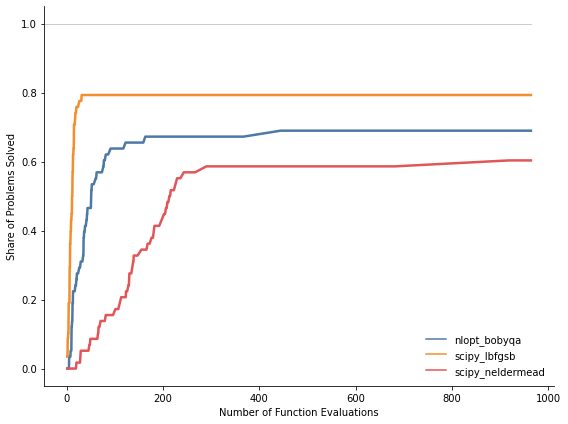

In [4]:
results_small = run_benchmark(
    problems["small"],
    optimizers,
    logging_directory="benchmark_logs_small",
    n_cores=cpu_count(),
)
fig = profile_plot(
    problems=problems["small"],
    results=results_small,
)

### Optimizer performance on the medium dimensional problem set

In [ ]:
results_small = run_benchmark(
    problems["medium"],
    optimizers,
    logging_directory="benchmark_logs_medium",
    n_cores=cpu_count(),
)
fig = profile_plot(
    problems=problems["medium"],
    results=results_small,
)

### Interpretation

One can see from these figures, that L-BFGS-B performs the best, both in speed and successful optimizations. An interesting observation here is L-BFGS-B's near invariance to function input scale/dimension, as it solves problems at nearly the same speed over both sets. The Nelder-Mead optimizer however does struggle a lot with the increase in dimension of input problems. However, this mostly affects the speed at which it solves problems, and not it's problem solving rate compared to the other two optimizers. From these figures it is clearly visible that not every optimizer can solve every problem set, but they can each solve a substantial amount. It is thus neither to easy nor to hard to solve.

### Quality of the benchmark set

The figures also show, that the benchmark set is well-constructed, since the problems are of varying difficulty to each optimizer. One can see this is in the difference solution rates, aswell as solving speed.

## Function tag dictionary

We constructed a dictionary of dictionaries for function attributes based on Thevenot's work. Attributes are "continuous", "convex", "seperable", "differentiable", "randomized_term", "parametric" which are assigned either True or False and "input_start" and "input_end" defining the possible dimensionality of the function's input domain with either integeres or "None". As an example we have inserted a snapshot of the function tag dictionary for the ackley function.
```
SCALAR_FUNCTIONS_TAGS = {
    "ackley": {
        "continuous": True,
        "convex": False,
        "separable": True,
        "differentiable": True,
        "mutimodal": True,
        "randomized_term": False,
        "parametric": True,
        "input_start": 1,
        "input_end": None,
    }
}
```

## Remarks on difficulties

We collected issues with Thevenot's code and materials in this csv file:

In [ ]:
remarks_on_thevenots_code = pd.read_csv("remarks_on_thevenots_code.csv")
remarks_on_thevenots_code

This includes sources with which we compared his work. Issues included false minimas or false minima locations as well as errors in coded mathematics of functions like missing brackets or exponents.
There are a few functions that currently do not work with their associated problems and are thus collected in a seperate dictionary and can be accessed as "scalar_functions_extra" via the get_benchmark_problems function. These functions have a variety of issues, rooting among other issues in either random components or one-dimensionality. This set includes 9 problems for 6 functions. 

## Ideas on how to scale problems with arbitrary dimensions in the future

As of now the get_benchmark_problems function filters the "scalar_functions" problem set by their input dimension (the length of the vectors in "start_x" and "solution_x", for an example see the problem for the Ackley function below). In the future one could create problem sets on the fly for a specific dimension. A function which utilizes the dimension properties given in SCALAR_FUNCTION_TAGS can filter all elliglble functions for a problem dimension d. It would then write scalable problems, like that of the Ackley function, according to the given dimension to be equal to this manual notation:
```
SCALAR_FUNCTIONS_PROBLEMS = {
    "ackley_good_start": {
        "criterion": ackley,
        "start_x": np.full(d, 0.45),
        "solution_x": np.zeros(d),
        "start_criterion": ackley("start_x"),
        "solution_criterion": 0,
    }
}
```

### Functions that easily scale

There are a number of functions where the minimum is always the same whatever the dimension of the function input and the minimum location is a unit vector multiplied by a scalar of arbitrary length. For example the Ackley function's global minimum is always 0 and it's global minimum is always located at the zero vector.
```
def ackley(x):
    out = (
        -20 * np.exp(-0.2 * np.sqrt(np.mean(x**2)))
        - np.exp(np.mean(np.cos(2 * np.pi * x)))
        + 20
        + np.exp(1)
    )
    return out

SCALAR_FUNCTIONS_PROBLEMS = {
    "ackley_good_start": {
        "criterion": ackley,
        "start_x": np.full(10, 0.45),
        "solution_x": np.zeros(10),
        "start_criterion": 4.053325482003931,
        "solution_criterion": 0,
    }
}
```
These functions, like the Ackley function in the example above, work with inputs of arbitrary length. Some functions had to be rewritten from Thevenot's original code to allow for more than two dimensions (e.g. Ackley N.4 and Brown). The above problem ("ackley_good_start") is of dimension 10, but could easily be adjusted to an arbitrary dimension by replacing dimension 10 with a variable in "start_x" and "solution_x".
Functions which are multi-dimensional and need no further work except from the arbitrary dimension implementation are: 
Ackley, Ackley N.4, Alpine N.1, Brown, Exponential,
Griewank, Happy Cat, Powell, Rastrigin, Rosenbrock, Rotated Hyper-Ellipsoid, Salomon, Schwefel, Schwefel 2.20, Schwefel 2.21, Schwefel 2.22, Schwefel 2.23, Sphere, Sum Squares, Thevenot, Xin-She Yang N.2, Xin-She Yang N.3, Xin-She Yang N.4 and Zakharov.

### Functions that need specific work

Some functions minima or minima locations depend on their dimension and thus need a bit more work to make them usable with arbitrary dimensions. For example the Alpine N.2 function's minimum is located at
```
f(x_minimum) = -2.808 ** d
```
where d is the the dimension of the function input x_minimum. Functions with similar problems of which we have implemented certain scalar cases which only need to be generalized are Alpine2, Dixon-Price, Trid, Qing, Styblinski-Tank.

### Functions which cannot be easily changed from the two-dimensional case

There are functions which are multi-dimensional according to literature but rarely used outside of the two-dimensional for differing reasons, such as for example changing global minima. These functions would require a substantial amount of work and research to implement for multi-dimensionality and it is not clear whether this makes sense. These functions are Langermann, both Perm Functions, Michalewicz, Shubert, Shubert N.3 and Shubert N. 4.